## Overview
Quickly demonstrates the NFourSID package.
Familiarity with subspace-identification, Kalman filtering and state-space models are assumed.

In this notebook, the following steps will be illustrated:
* Define a state-space model,
* Create a training-set and simulate measurement noise,
* Perform subspace identification and determine the order of the system which will be identified,
* Obtain a fitted state-space model,
* Use a Kalman filter to obtain predictions.

First, let's define the parameters of the state-space model and do some housekeeping.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nfoursid.kalman import Kalman
from nfoursid.nfoursid import NFourSID
from nfoursid.state_space import StateSpace

pd.set_option('display.max_columns', None)
np.random.seed(0)  # reproducable results

NUM_TRAINING_DATAPOINTS = 1000  # create a training-set by simulating a state-space model with this many datapoints
NUM_TEST_DATAPOINTS = 20  # same for the test-set
INPUT_DIM = 3
OUTPUT_DIM = 2
INTERNAL_STATE_DIM = 4  # actual order of the state-space model in the training- and test-set
NOISE_AMPLITUDE = .1  # add noise to the training- and test-set
FIGSIZE = 8

# define system matrices for the state-space model of the training- and test-set
A = np.array([
    [1,  .01,    0,   0],
    [0,    1,  .01,   0],
    [0,    0,    1, .02],
    [0, -.01,    0,   1],
]) / 1.01
B = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 1],
]
) / 3
C = np.array([
    [1, 0, 1,  1],
    [0, 0, 1, -1],
])
D = np.array([
    [1, 0, 1],
    [0, 1, 0]
]) / 10

Create a training-set by adding noise to a state-space model:

In [2]:
state_space = StateSpace(A, B, C, D)
for _ in range(NUM_TRAINING_DATAPOINTS):
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE

    state_space.step(input_state, noise)

The state-space model has 3 inputs, a 4-dimensional internal state vector and 2 outputs. 
Plotting the dataset can be done using `StateSpace.plot_input_output`.

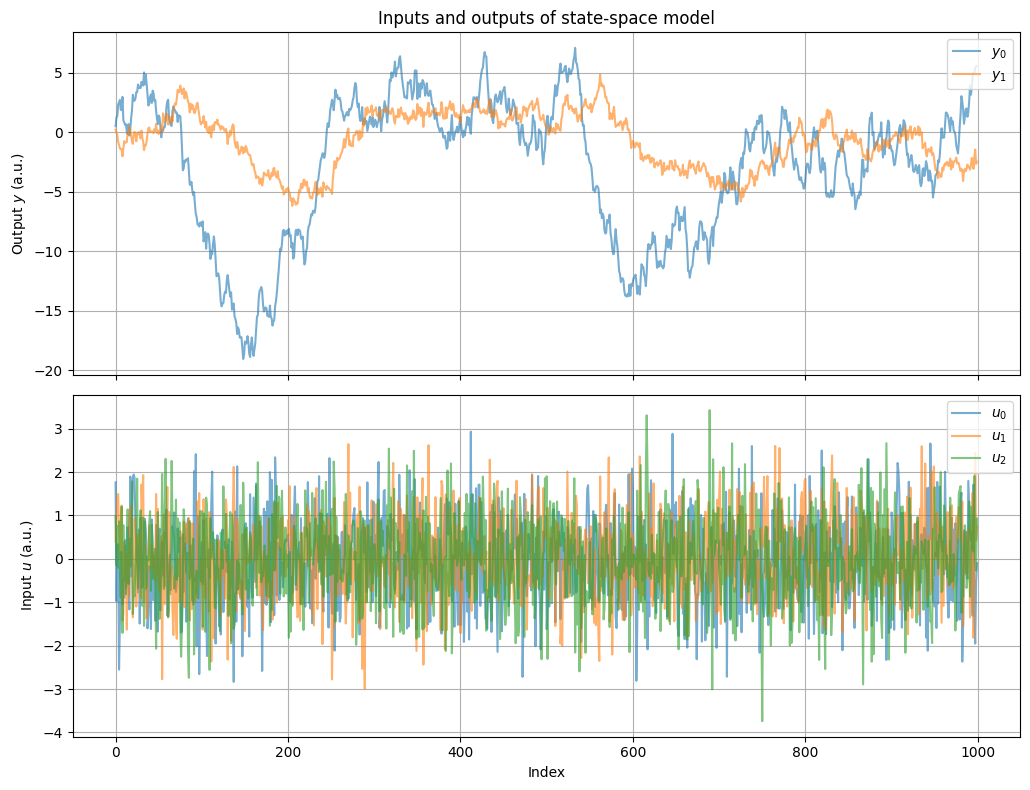

In [3]:
figsize = (1.3 * FIGSIZE, FIGSIZE)
fig = plt.figure(figsize=figsize)
state_space.plot_input_output(fig)  # the state-space model can plot its inputs and outputs
fig.tight_layout()

At the moment, suppose that we don't know the order of the internal state vector.
Let's perform subspace identification.

In [4]:
nfoursid = NFourSID(
    state_space.to_dataframe(),  # the state-space model can summarize inputs and outputs as a dataframe
    output_columns=state_space.y_column_names,
    input_columns=state_space.u_column_names,
    num_block_rows=10
)
nfoursid.subspace_identification()

Plotting the eigenvalues of the estimated observability matrix is done with `NFourSID.plot_eigenvalues`.

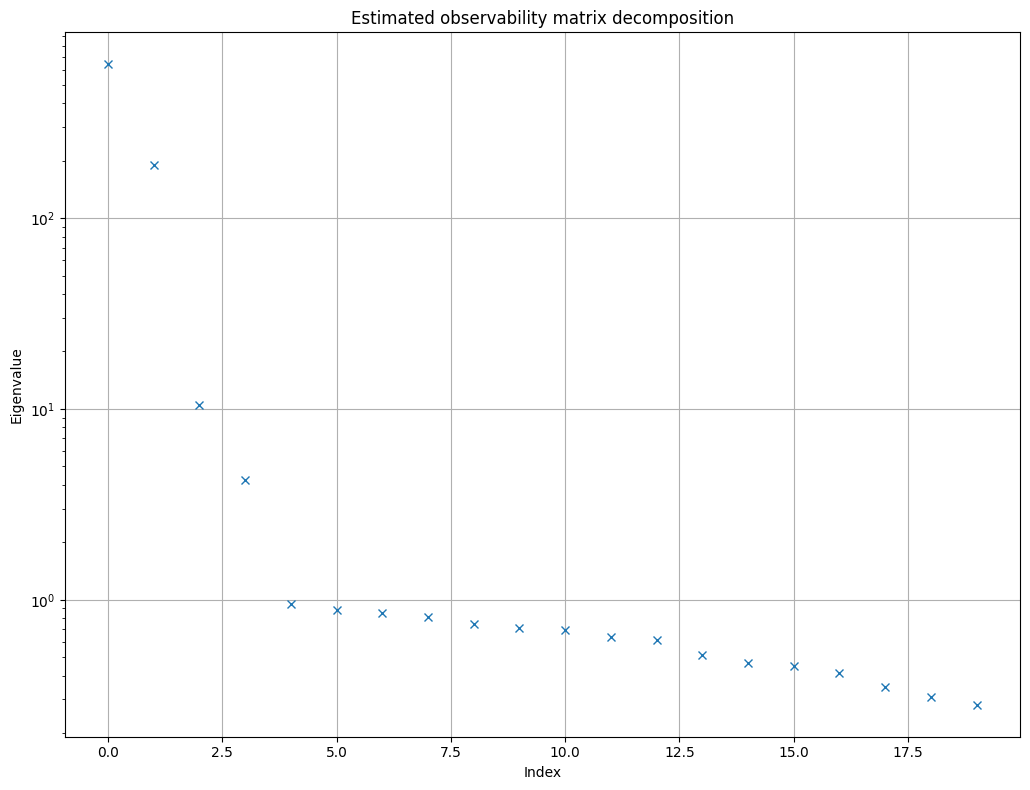

In [5]:
fig, ax = plt.subplots(figsize=figsize)
nfoursid.plot_eigenvalues(ax)
fig.tight_layout()

This gives us a signal that the order of the state-space model is 4.
Let's identify the system matrices.

In [6]:
ORDER_OF_MODEL_TO_FIT = 4
state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

Generate a test-set and use Kalman filtering to evaluate prediction performance:

In [7]:
kalman = Kalman(state_space_identified, covariance_matrix)
state_space = StateSpace(A, B, C, D)  # new data for the test-set
for _ in range(NUM_TEST_DATAPOINTS):  # make a test-set
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE

    y = state_space.step(input_state, noise)  # generate test-set
    kalman.step(y, input_state)  # the Kalman filter sees the output and input, but not the actual internal state

Plot the filtered state of the Kalman filter using `Kalman.plot_filtered`.
The top graph shows the output of the Kalman filter against the filtered states.
Expected standard deviation is plotted as error bars.

The bottom graph zooms in on the filtering error.
In this plot, expected standard deviation is plotted as dotted lines.

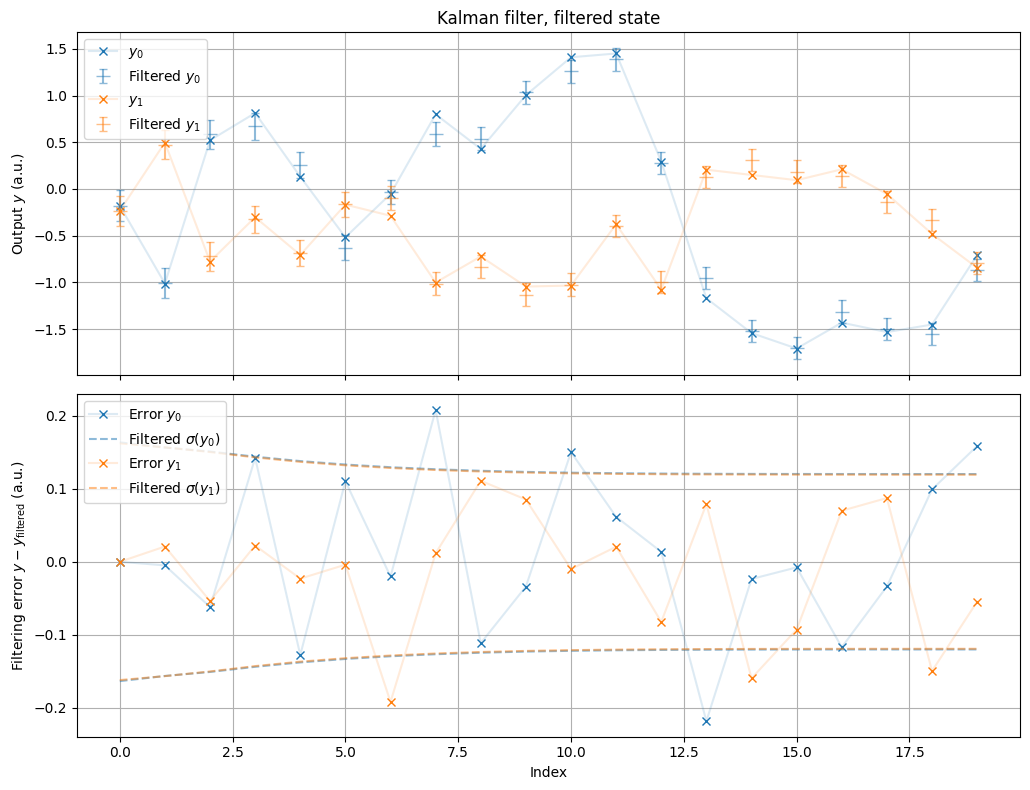

In [8]:
fig = plt.figure(figsize=figsize)
kalman.plot_filtered(fig)
fig.tight_layout()

The Kalman filter also provides an prediction of the next internal state.
Based on the predicted internal state and the fitted model, it is possible to estimate the output of the next timestep.
It is necessary to correct the output prediction with the known input of the next timestep using the estimated system matrix `Kalman.state_space.d`.
This is not a limitation, because the inputs and estimated system matrices are known to the experimenter.

The predicted outputs can be plotted using `Kalman.plot_predicted`, like the previous plot of the filtered states.
The one-step ahead predicted output, assuming no further inputs, is shown as a star with expected standard deviation as error bars.

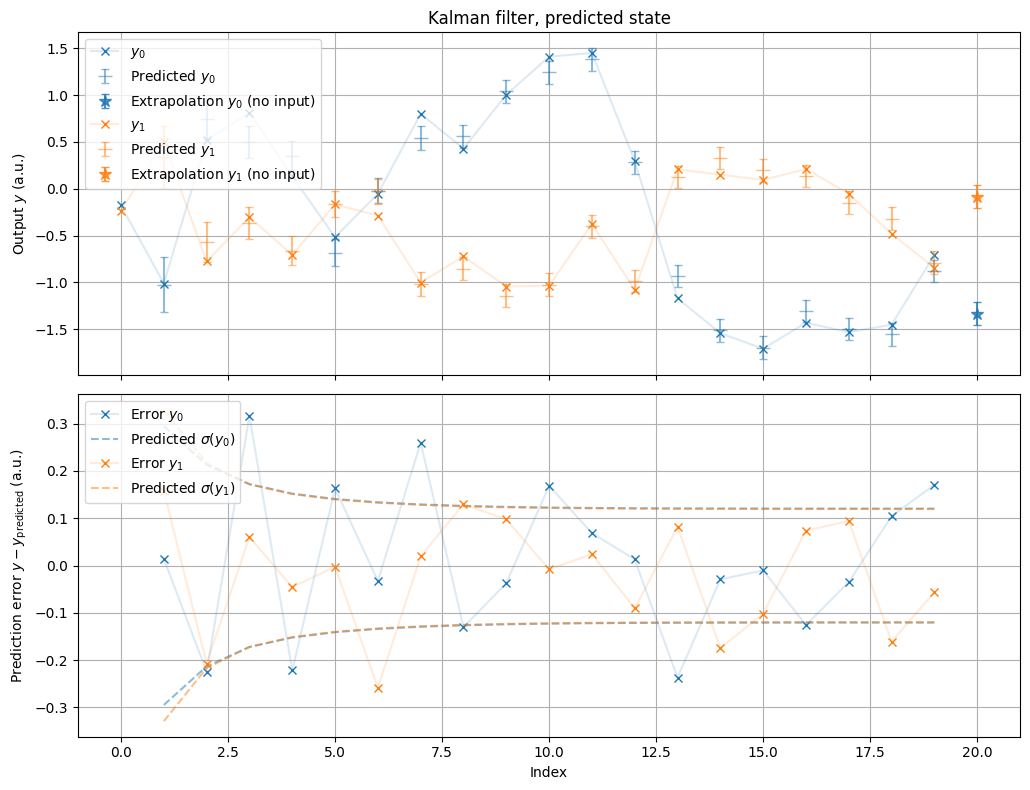

In [9]:
fig = plt.figure(figsize=figsize)
kalman.plot_predicted(fig)
fig.tight_layout()

We can access the output data of the Kalman filter using `Kalman.to_dataframe()`.
This returns a dataframe for all output columns containing
* The actual output, which was given to the Kalman filter using `Kalman.step`,
* The filtered output state,
* The next predicted state, assuming no further inputs,
* The next predicted state, adjusted ex-post with the next input.

In [10]:
kalman.to_dataframe()

$y_0$                                                         \
      actual  filtered                    next predicted (no input)   
      output    output standard deviation                    output   
0  -0.178945 -0.178940           0.163462                 -1.216790   
1  -1.011690 -1.006693           0.156388                  0.611477   
2   0.520904  0.582883           0.150897                  0.634508   
3   0.812598  0.670394           0.143842                  0.367806   
4   0.131519  0.259228           0.137846                 -0.868412   
5  -0.517449 -0.627665           0.133104                  0.086522   
6  -0.053167 -0.032980           0.129434                  0.512773   
7   0.798916  0.591154           0.126639                  0.584490   
8   0.428488  0.539967           0.124550                  0.898774   
9   1.003207  1.037168           0.123027                  1.030881   
10  1.409100  1.259052           0.121953                  1.775888   
11  1.449779  1.388264           0.121222                  0.255999   
12  0.293254  0.279755           0.120746                 -0.772931   
13 -1.169319 -0.951036           0.120450                 -1.521715   
14 -1.541937 -1.518311           0.120277                 -1.707448   
15 -1.707321 -1.699594           0.120180                 -1.269433   
16 -1.430401 -1.313311           0.120131                 -1.344939   
17 -1.531490 -1.497655           0.120107                 -1.704550   
18 -1.450757 -1.549770           0.120097                 -0.849683   
19 -0.707673 -0.866138           0.120093                 -1.332263   

                                                                           \
                      next predicted (input corrected)                      
   standard deviation                           output standard deviation   
0            0.294686                        -1.026086           0.294686   
1            0.213172                         0.745210           0.213172   
2            0.172138                         0.496306           0.172138   
3            0.152106                         0.353258           0.152106   
4            0.140827                        -0.680649           0.140827   
5            0.133847                        -0.020756           0.133847   
6            0.129284                         0.539107           0.129284   
7            0.126221                         0.558550           0.126221   
8            0.124151                         1.040365           0.124151   
9            0.122764                         1.240320           0.122764   
10           0.121853                         1.381071           0.121853   
11           0.121273                         0.280161           0.121273   
12           0.120918                        -0.932432           0.120918   
13           0.120711                        -1.512924           0.120711   
14           0.120597                        -1.697032           0.120597   
15           0.120538                        -1.304661           0.120538   
16           0.120510                        -1.496521           0.120510   
17           0.120498                        -1.555202           0.120498   
18           0.120493                        -0.878534           0.120493   
19           0.120491                              NaN           0.120491   

       $y_1$                                                         \
      actual  filtered                    next predicted (no input)   
      output    output standard deviation                    output   
0  -0.233697 -0.233619           0.162045                  0.095081   
1   0.496638  0.475776           0.156611                 -0.502705   
2  -0.776304 -0.722512           0.150240                 -0.430735   
3  -0.302252 -0.324489           0.142888                 -0.547100   
4  -0.706159 -0.683050           0.136813                 -0.176261   
5  -0.167407 -0.163382           